# November ??th, 2021 (k-means common space)

**Motivation**: Removing outlier timepoints helps(?) <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def show_corrs(key):
    try:
        net_ca = Network(mice, key, 'ca2').load_network()
        net_bold = Network(mice, key, 'bold-lite').load_network()
    except TypeError:
        return 
    
    fig, axes = create_figure(2, 4, (12.8, 6))

    for i, _net in enumerate([net_bold, net_ca]):
        xl = _net.adj[_net.l_ids][:, _net.l_ids]
        xr = _net.adj[_net.r_ids][:, _net.r_ids]
        vmin = np.min(_net.adj)
        vmax = np.max(_net.adj)

        j = 2 * i
        im = axes[0, j].imshow(xl, vmin=vmin, vmax=vmax, cmap='Spectral_r')
        plt.colorbar(im, ax=axes[0, j], shrink=0.75)
        axes[0, j].set_title(f"{_net.mode} (left hemis)")

        j = 2 * i + 1
        im = axes[0, j].imshow(xr, vmin=vmin, vmax=vmax, cmap='Spectral_r')
        plt.colorbar(im, ax=axes[0, j], shrink=0.75)
        axes[0, j].set_title(f"{_net.mode} (right hemis)")

        j = 2 * i
        sns.histplot(
            data=xl[xl.nonzero()],
            label='left hemis',
            stat='percent',
            color='C0',
            bins=30,
            alpha=0.7,
            ax=axes[1, j],
        )
        sns.histplot(
            data=xr[xr.nonzero()],
            label='right hemis',
            stat='percent',
            color='C3',
            bins=30,
            alpha=0.7,
            ax=axes[1, j],
        )
        axes[1, j].set_xlabel('correlation')
        axes[1, j].set_title(f"{_net.mode} corr hist")
        axes[1, j].legend()

        j = 2 * i + 1
        sns.ecdfplot(
            data=xl[xl.nonzero()],
            label='left hemis',
            color='C0',
            lw=2,
            ax=axes[1, j],
        )
        sns.ecdfplot(
            data=xr[xr.nonzero()],
            label='right hemis',
            color='C3',
            lw=2,
            ax=axes[1, j],
        )
        axes[1, j].set_xlabel('correlation')
        axes[1, j].set_title(f"{_net.mode} corr ecdf")
        axes[1, j].legend()
        axes[1, j].grid()
    fig.suptitle(key, fontsize=15, y=1.03)
    plt.show()
    
    return (net_ca, net_bold), (fig, axes)

In [3]:
mice = Mice((192, 4))

In [4]:
# 
in_house = '/home/hadi/Documents/Ca-fMRI/Yale/atlases_templates'
in_house = pjoin(in_house, 'Symmetric_N162_0.20.nii.gz')
in_house = ants.image_read(in_house)
mask = in_house.get_mask().numpy().astype(bool)

# 
m_l = np.zeros_like(mask)
m_r = np.zeros_like(mask)
m_l[:len(mask)//2] = 1
m_r[len(mask)//2:] = 1
m_l *= mask
m_r *= mask

# 
id2vox = {i + 1: vox for i, vox in enumerate(zip(*np.where(mask)))}
vox2id = {vox: idx for idx, vox in id2vox.items()}

voxels_l = [vox2id[vox] for vox in zip(*np.where(m_l))]
voxels_r = [vox2id[vox] for vox in zip(*np.where(m_r))]

l_ids = np.where(np.isin(list(id2vox), voxels_l))[0]
r_ids = np.where(np.isin(list(id2vox), voxels_r))[0]
assert not set(l_ids).intersection(r_ids)

len(id2vox), len(voxels_l), len(voxels_r), len(l_ids), len(r_ids)

(53520, 26760, 26760, 26760, 26760)

## Bad timepoints (for each voxel)

In [10]:
in_house = '/home/hadi/Documents/Ca-fMRI/Yale/atlases_templates'
in_house = pjoin(in_house, 'Symmetric_N162_0.20.nii.gz')
in_house = ants.image_read(in_house)
mask = in_house.get_mask().numpy().astype(bool)

In [11]:
m_l = np.zeros_like(mask)
m_r = np.zeros_like(mask)
m_l[:len(mask)//2] = 1
m_r[len(mask)//2:] = 1

m_l *= mask
m_r *= mask

In [12]:
id2vox = {i + 1: vox for i, vox in enumerate(zip(*np.where(mask)))}
vox2id = {vox: idx for idx, vox in id2vox.items()}

voxels_l = [vox2id[vox] for vox in zip(*np.where(m_l))]
voxels_r = [vox2id[vox] for vox in zip(*np.where(m_r))]

l_ids = np.where(np.isin(list(id2vox), voxels_l))[0]
r_ids = np.where(np.isin(list(id2vox), voxels_r))[0]
assert not set(l_ids).intersection(r_ids)

len(id2vox), len(voxels_l), len(voxels_r), len(l_ids), len(r_ids)

(53520, 26760, 26760, 26760, 26760)

In [13]:
key = 'sub-SLC02_ses-3_run-5'
file = next(
    f for f in os.listdir(mice.cfg.npy_dir)
    if all(e in f for e in [key, 'N162'])
)
x = np.load(pjoin(mice.cfg.npy_dir, file))

In [14]:
nb_sds = 2
bad_timepoints = {}
sds = {}

for idx, vox in id2vox.items():
    vec = x[vox]
    sd = vec.std()
    bad = np.where(np.abs(vec) > nb_sds * sd)[0]
    
    sds[idx] = sd
    bad_timepoints[idx] = bad
    
x_filt = np.zeros_like(x)
for idx, vox in id2vox.items():
    vec = x[vox].copy()
    np.put(vec, bad_timepoints[idx], np.nan)
    x_filt[vox] = vec
    
x_filt2 = np.delete(x_filt, exclude, axis=-1)
x_filt2.shape, x_filt.shape

In [15]:
x_filt = np.zeros_like(x)
for idx, vox in id2vox.items():
    vec = x[vox].copy()
    np.put(vec, bad_timepoints[idx], np.nan)
    x_filt[vox] = vec
    
sds_filt = {
    idx: np.nanstd(x_filt[vox]) for
    idx, vox in id2vox.items()
}

num_bad_ids = [
    len(bad_ids) for idx, bad_ids
    in bad_timepoints.items()
]

<AxesSubplot:ylabel='Count'>

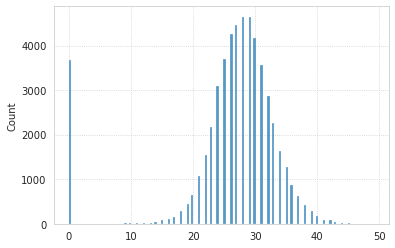

In [16]:
sns.histplot(num_bad_ids)

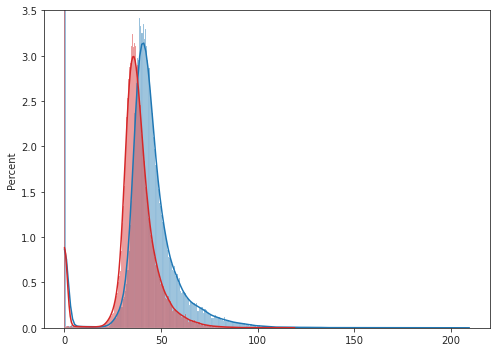

In [17]:
fig, ax = create_figure(1, 1, (7, 5))
sns.histplot(list(sds.values()), kde=True, stat='percent', color='C0')
sns.histplot(list(sds_filt.values()), kde=True, stat='percent', color='C3')
ax.set_ylim(0, 3.5)
plt.show()

In [18]:
bad_counts = []
for v in bad_timepoints.values():
    bad_counts.extend(list(v))
bad_counts = collections.Counter(bad_counts)
bad_counts = bad_counts.most_common()

In [21]:
threshold = np.quantile([c for _, c in bad_counts], 0.9)
threshold

4818.200000000001

<matplotlib.lines.Line2D object at 0x7f6b8a292880>

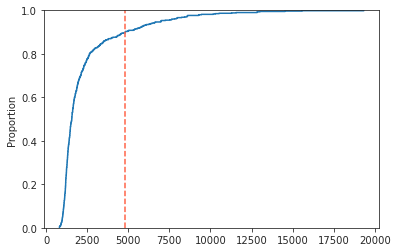

In [22]:
sns.ecdfplot([c for _, c in bad_counts])
plt.axvline(threshold, color='tomato', ls='--')

In [23]:

exclude

[
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    60,
    61,
    155,
    158,
    159,
    160,
    172,
    173,
    174,
    175,
    176,
    177,
    178,
    179,
    180,
    181,
    218,
    219,
    220,
    265,
    266,
    267,
    268,
    269,
    281,
    377,
    507,
    508,
    509,
    514,
    515,
    516,
    523,
    524,
    571
]

In [24]:
x_filt2 = np.delete(x_filt, exclude, axis=-1)
x_filt2.shape, x_filt.shape

((60, 46, 81, 540), (60, 46, 81, 600))

In [25]:
nb_sds = 2
bad_timepoints_filt2 = {}
sds_filt2 = {}

for idx, vox in id2vox.items():
    vec = x_filt2[vox]
    sd = np.nanstd(vec)
    bad = np.where(np.abs(vec) > nb_sds * sd)[0]
    
    sds_filt2[idx] = sd
    bad_timepoints_filt2[idx] = bad

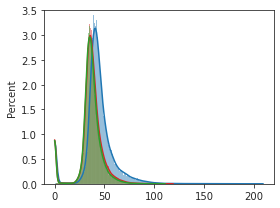

In [27]:
fig, ax = create_figure(1, 1, (4, 3))
sns.histplot(list(sds.values()), kde=True, stat='percent', color='C0')
sns.histplot(list(sds_filt.values()), kde=True, stat='percent', color='C3')
sns.histplot(list(sds_filt2.values()), kde=True, stat='percent', color='C2')
ax.set_ylim(0, 3.5)
plt.show()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [30]:
list(parc)

['regions', 'parcel', 'eroded', 'cluster_centers', 'mask_l', 'mask_r', 'radius']

In [31]:
parc['parcel'].shape

(60, 46, 81)

<matplotlib.image.AxesImage object at 0x7f6b3f413520>

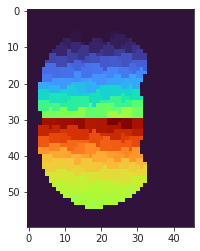

In [32]:
plt.imshow(parc['parcel'][..., 40], cmap='turbo')

In [34]:
mask_tr, in_house_tr, parcel_tr, ml_tr, mr_tr = filter_boundaries(
    [mask, in_house.numpy(), parc['parcel'], parc['mask_l'], parc['mask_r']], mask)

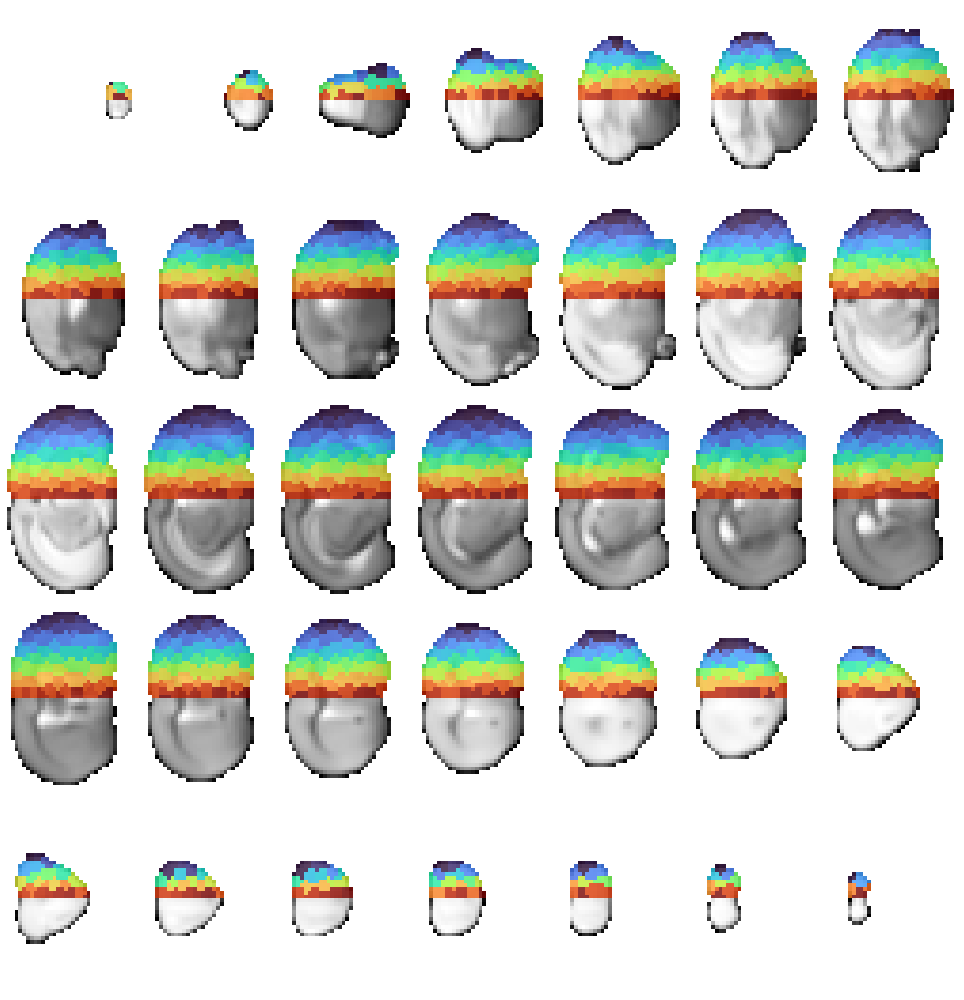

In [35]:
fig, axes = create_figure(5, 7, (13.5, 14))

for i, idx in enumerate(range(1, mask_tr.shape[-1], 2)):
    ax = axes.ravel()[i]

    x2plt = np.ma.masked_where(~mask_tr[..., idx], in_house_tr[..., idx])
    ax.imshow(x2plt, cmap='Greys_r')

    x2plt = np.ma.masked_where(~ml_tr[..., idx], parcel_tr[..., idx])
    ax.imshow(x2plt, alpha=0.8, cmap='turbo')

remove_ticks(axes)
plt.show()

In [36]:
roi_masks = {
    idx: parc['parcel'] == idx for idx in
    np.unique(parc['parcel'][parc['parcel'].nonzero()])
}

In [37]:
key = 'sub-SLC02_ses-3_run-5'
file = next(
    f for f in os.listdir(mice.cfg.npy_dir)
    if all(e in f for e in [key, 'N162'])
)
x = np.load(pjoin(mice.cfg.npy_dir, file))

x_filt = np.zeros_like(x)
for idx, vox in id2vox.items():
    vec = x[vox].copy()
    np.put(vec, bad_timepoints[idx], np.nan)
    x_filt[vox] = vec

x_filt = np.delete(x_filt, exclude, axis=-1)
x_filt.shape, x.shape

((60, 46, 81, 540), (60, 46, 81, 600))

In [38]:
data = {
    idx: bn.nanmedian(x_filt[m], 0)
    for idx, m in roi_masks.items()
}
sd = {
    idx: bn.nanstd(v) for
    idx, v in data.items()
}

<AxesSubplot:ylabel='Count'>

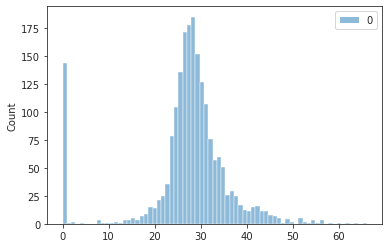

In [39]:
sns.histplot(sd.values())

In [40]:
len(data)

2000

In [41]:
data = {
    idx: v for idx, v in data.items()
    if bn.nanstd(v) > 20
}
len(data)

1794

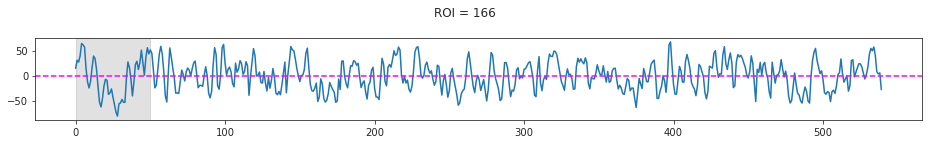

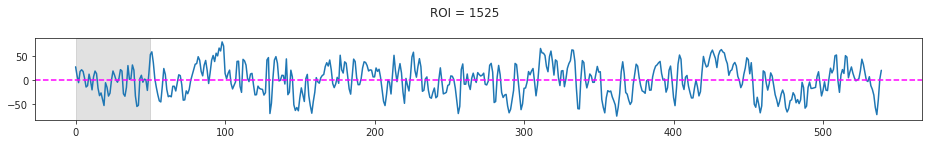

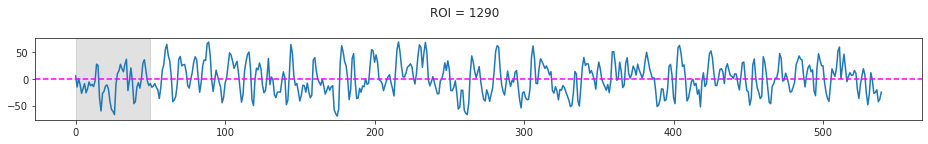

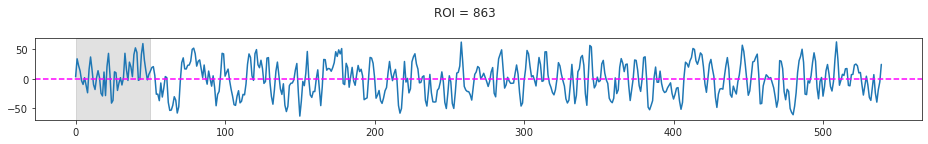

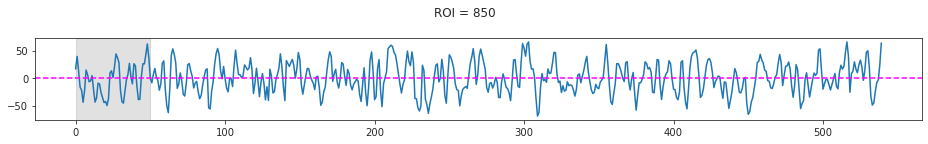

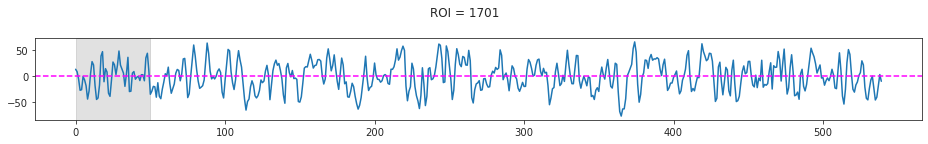

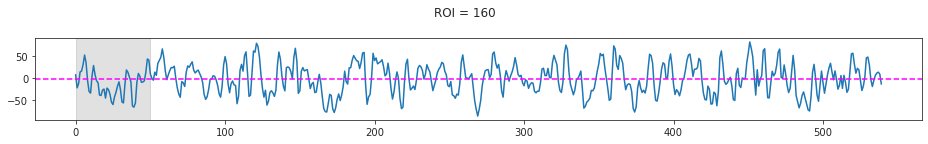

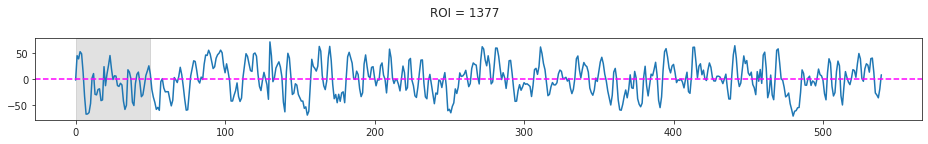

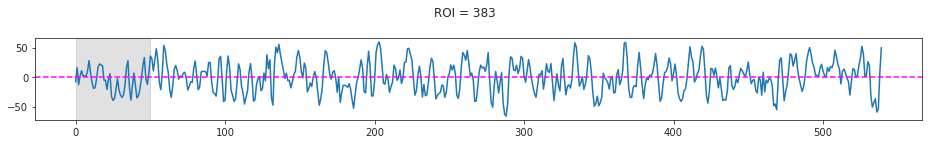

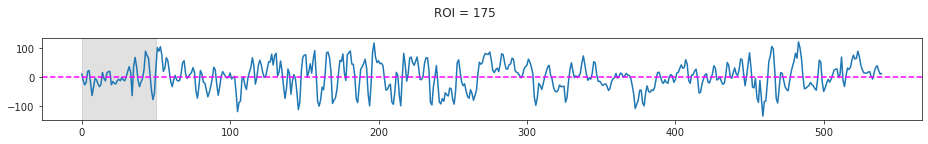

In [42]:
rng = get_rng()

for idx in rng.choice(list(data), size=10):
    fig, ax = create_figure(1, 1, (13, 2), 'all')
    ax.plot(data[idx].T)
    ax.plot(np.mean(data[idx], 0), color='k', ls='--')
    ax.plot(np.median(data[idx], 0), color='gold', ls='-.')
    ax.axvspan(0, 50, color='dimgrey', alpha=0.2)
    ax.axhline(bn.nanmean(data[idx]), color='magenta', ls='--')

    fig.suptitle(f"ROI = {idx}")

    plt.show()
    print('\n')

In [43]:
from nancorrmp.nancorrmp import NaNCorrMp

adj, p = NaNCorrMp.calculate_with_p_value(pd.DataFrame(data))

In [44]:
adj = adj.values
np.fill_diagonal(adj, 0.)

<matplotlib.image.AxesImage object at 0x7f6b1e350790>

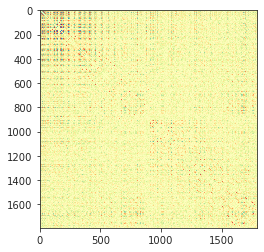

In [45]:
plt.imshow(adj, cmap='Spectral_r')

In [46]:
d = (1 - adj) / 2
np.fill_diagonal(d, 0.)

In [47]:
from analysis.hierarchical import sp_hier, get_clust_graph

In [48]:
z = sp_hier.linkage(
    sp_dist.squareform(d),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)

In [78]:
result = get_clust_graph(
    linkage_mat=z,
    labels=list(data),
    num_clusters=2,
)

In [79]:
list(result['cluster_assigns'])

[1, 2]

In [80]:
cl_vol = np.zeros(mask.shape, dtype=float)
for c_idx, clist in result['cluster_assigns'].items():
    for region in clist:
        cl_vol[roi_masks[region]] = c_idx

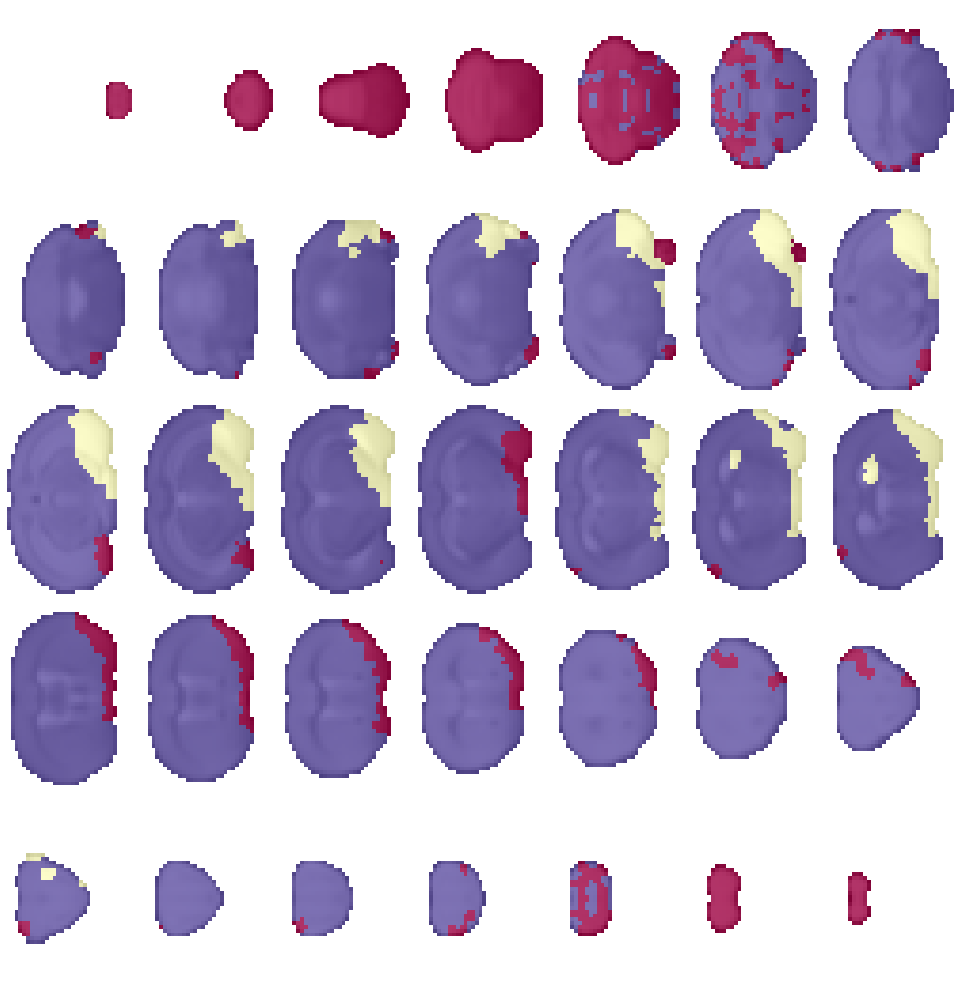

In [82]:
cl_vol_tr = filter_boundaries(cl_vol, mask)
fig, axes = create_figure(5, 7, (13.5, 14))

for i, idx in enumerate(range(1, mask_tr.shape[-1], 2)):
    ax = axes.ravel()[i]

    x2plt = np.ma.masked_where(~mask_tr[..., idx], in_house_tr[..., idx])
    ax.imshow(x2plt, cmap='Greys_r')

    x2plt = np.ma.masked_where(~mask_tr[..., idx], cl_vol_tr[..., idx])
    ax.imshow(x2plt, alpha=0.8, cmap='Spectral')

remove_ticks(axes)
plt.show()

In [83]:
x_filt.shape

(60, 46, 81, 540)

In [93]:
data_2kmean = np.concatenate([x_filt[vox].reshape(1, -1) for vox in id2vox.values()])
data_2kmean[np.isnan(data_2kmean)] = 0.0
data_2kmean.shape

(53520, 540)

In [122]:
centroids, model = fit_kmeans(data_2kmean, 3, 'euclidean', 42)

In [123]:
np.round(dist2sim(sp_dist.squareform(sp_dist.pdist(centroids, 'correlation'))), 3)

array([[ 1.   , -0.704, -0.318],
       [-0.704,  1.   , -0.422],
       [-0.318, -0.422,  1.   ]])

array([[ 1.        , -0.59003335, -0.16681425, -0.18803658,  0.22236474],
       [-0.59003335,  1.        , -0.60274872,  0.05537245, -0.0231607 ],
       [-0.16681425, -0.60274872,  1.        , -0.06907459, -0.07822524],
       [-0.18803658,  0.05537245, -0.06907459,  1.        , -0.96025722],
       [ 0.22236474, -0.0231607 , -0.07822524, -0.96025722,  1.        ]])

In [124]:
cl_vox = model.predict(data_2kmean) + 1
cl_vol = np.zeros(mask.shape, dtype=float)

for c_idx, vox in zip(cl_vox, id2vox.values()):
    cl_vol[vox] = c_idx

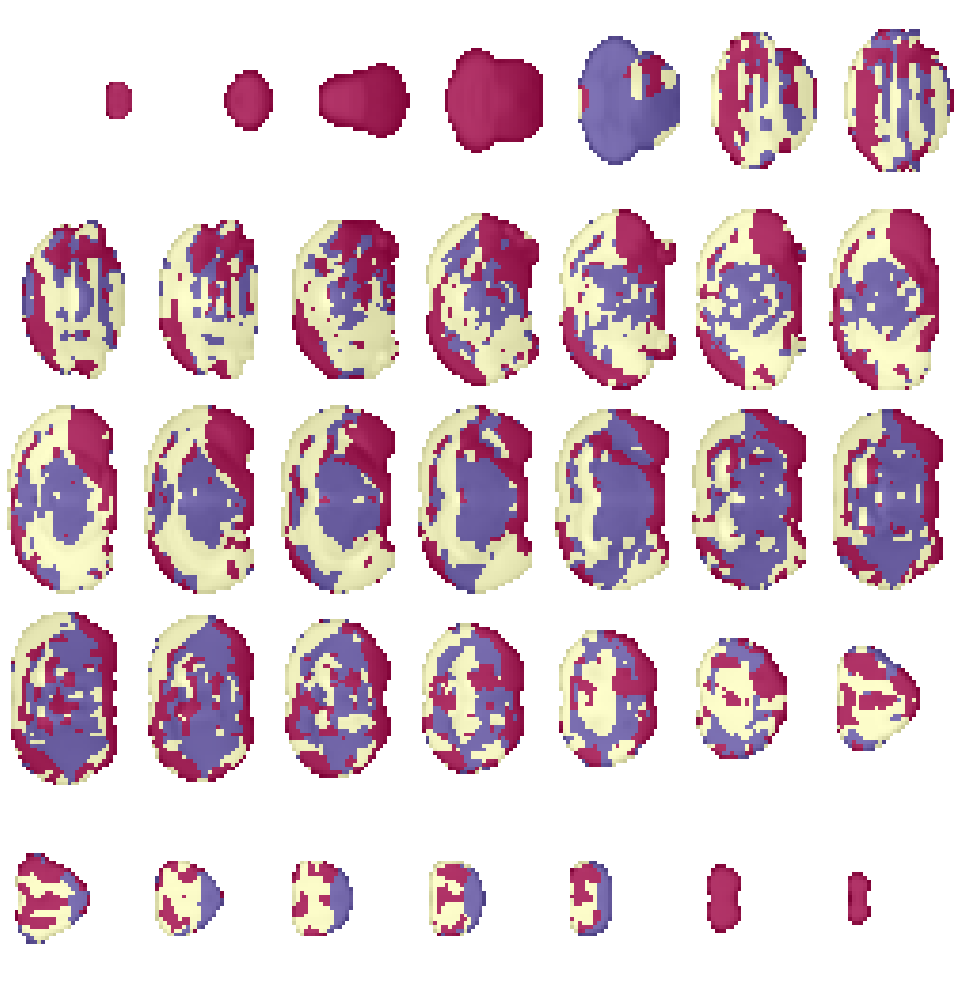

In [125]:
cl_vol_tr = filter_boundaries(cl_vol, mask)
fig, axes = create_figure(5, 7, (13.5, 14))

for i, idx in enumerate(range(1, mask_tr.shape[-1], 2)):
    ax = axes.ravel()[i]

    x2plt = np.ma.masked_where(~mask_tr[..., idx], in_house_tr[..., idx])
    ax.imshow(x2plt, cmap='Greys_r')

    x2plt = np.ma.masked_where(~mask_tr[..., idx], cl_vol_tr[..., idx])
    ax.imshow(x2plt, alpha=0.8, cmap='Spectral')

remove_ticks(axes)
plt.show()

## Loop over all

In [5]:
from analysis.hierarchical import sp_hier, get_clust_graph
from register.parcellation import kmeans_parcellation
from nancorrmp.nancorrmp import NaNCorrMp

In [6]:
mice = Mice((192, 4))
mice.setup_func_data()

In [7]:
# 
in_house = '/home/hadi/Documents/Ca-fMRI/Yale/atlases_templates'
in_house = pjoin(in_house, 'Symmetric_N162_0.20.nii.gz')
in_house = ants.image_read(in_house)
mask = in_house.get_mask().numpy().astype(bool)

# 
m_l = np.zeros_like(mask)
m_r = np.zeros_like(mask)
m_l[:len(mask)//2] = 1
m_r[len(mask)//2:] = 1
m_l *= mask
m_r *= mask

# 
id2vox = {i + 1: vox for i, vox in enumerate(zip(*np.where(mask)))}
vox2id = {vox: idx for idx, vox in id2vox.items()}

voxels_l = [vox2id[vox] for vox in zip(*np.where(m_l))]
voxels_r = [vox2id[vox] for vox in zip(*np.where(m_r))]

l_ids = np.where(np.isin(list(id2vox), voxels_l))[0]
r_ids = np.where(np.isin(list(id2vox), voxels_r))[0]
assert not set(l_ids).intersection(r_ids)

len(id2vox), len(voxels_l), len(voxels_r), len(l_ids), len(r_ids)

(53520, 26760, 26760, 26760, 26760)

In [26]:
parc = kmeans_parcellation(mask, 1000, lr_axis=0)
roi_masks = {
    idx: parc['parcel'] == idx for idx in
    np.unique(parc['parcel'][parc['parcel'].nonzero()])
}

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [ ]:
nb_sds = 2
adj_all = []

for key in tqdm(mice.ca):
    sub, ses, run = mice.looper[key]
    if run == -1:
        continue

    try:
        file = next(
            f for f in os.listdir(mice.cfg.npy_dir)
            if all(e in f for e in [key, 'N162'])
        )
    except StopIteration:
        continue

    x = np.load(pjoin(mice.cfg.npy_dir, file))

    bad_timepoints, sds = {}, {}
    for idx, vox in id2vox.items():
        vec = x[vox]
        sd = vec.std()
        bad = np.where(np.abs(vec) > nb_sds * sd)[0]

        sds[idx] = sd
        bad_timepoints[idx] = bad

    bad_counts = []
    for v in bad_timepoints.values():
        bad_counts.extend(list(v))
    bad_counts = collections.Counter(bad_counts)
    bad_counts = bad_counts.most_common()
    threshold = np.quantile([c for _, c in bad_counts], 0.9)
    exclude = [t for t, c in bad_counts if c > threshold]
    exclude = sorted(exclude)

    x_filt = np.zeros_like(x)
    for idx, vox in id2vox.items():
        vec = x[vox].copy()
        np.put(vec, bad_timepoints[idx], np.nan)
        x_filt[vox] = vec
    x_filt = np.delete(x_filt, exclude, axis=-1)
    
    data = {
        idx: bn.nanmedian(x_filt[m], 0)
        for idx, m in roi_masks.items()
    }
    adj, p = NaNCorrMp.calculate_with_p_value(pd.DataFrame(data))
    adj = adj.values
    zeros = np.nanmean(np.abs(adj), 0) == 0
    adj[zeros][:, zeros] = np.nan
    adj[p.values >= 0.05] = np.nan
    adj_all.append(np.expand_dims(adj, 0))

adj_all = np.concatenate(adj_all, 0)
adj_all.shape

  0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
a = bn.nanmean(adj_all, 0)
_ = save_obj(a, f"adj_{len(parc['regions'])//2}", tmp_dir, 'npy')

In [ ]:
a = (a + a.T) / 2
d = (1 - a) / 2
d[np.isnan(d)] = 1.0
np.fill_diagonal(d, 0.)

In [ ]:
np.fill_diagonal(a, np.nan)
plt.imshow(a, cmap='Spectral_r')
plt.colorbar()

In [ ]:
linkage = sp_hier.linkage(
    sp_dist.squareform(d),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)

In [ ]:
_ = save_obj(linkage, f"linkage_{len(parc['regions'])//2}", tmp_dir, 'npy')

In [9]:
a = np.load(pjoin(tmp_dir, 'adj_1000.npy'))
linkage = np.load(pjoin(tmp_dir, 'linkage_1000.npy'))

<matplotlib.colorbar.Colorbar object at 0x7f98c041a5b0>

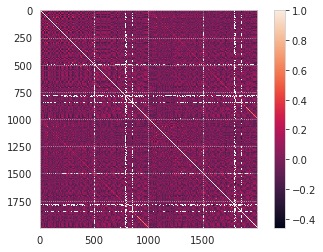

In [11]:
plt.imshow(a)
plt.colorbar()

In [15]:
a = (a + a.T) / 2
d = (1 - a) / 2
d[np.isnan(d)] = 1.0
np.fill_diagonal(d, 0.)

<matplotlib.colorbar.Colorbar object at 0x7f98c010ecd0>

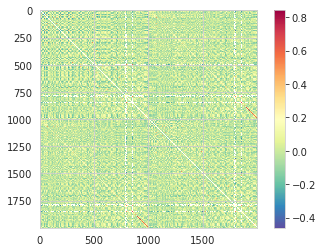

In [16]:
np.fill_diagonal(a, np.nan)
plt.imshow(a, cmap='Spectral_r')
plt.colorbar()

In [27]:
linkage = sp_hier.linkage(
    sp_dist.squareform(d),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)

In [28]:
linkage.shape

(1999, 4)

In [29]:
np.isnan(np.nanmean(np.abs(a), 0))

array([False, False, False, ..., False, False,  True])

In [24]:
linkage.shape

(1999, 4)

In [25]:
len(list(roi_masks)[:-1])

19999

In [31]:
result = get_clust_graph(
    linkage_mat=linkage,
    labels=list(roi_masks),
    num_clusters=8,
)
cl_vol = np.zeros(mask.shape, dtype=float)
for c_idx, clist in result['cluster_assigns'].items():
    for region in clist:
        cl_vol[roi_masks[region]] = c_idx

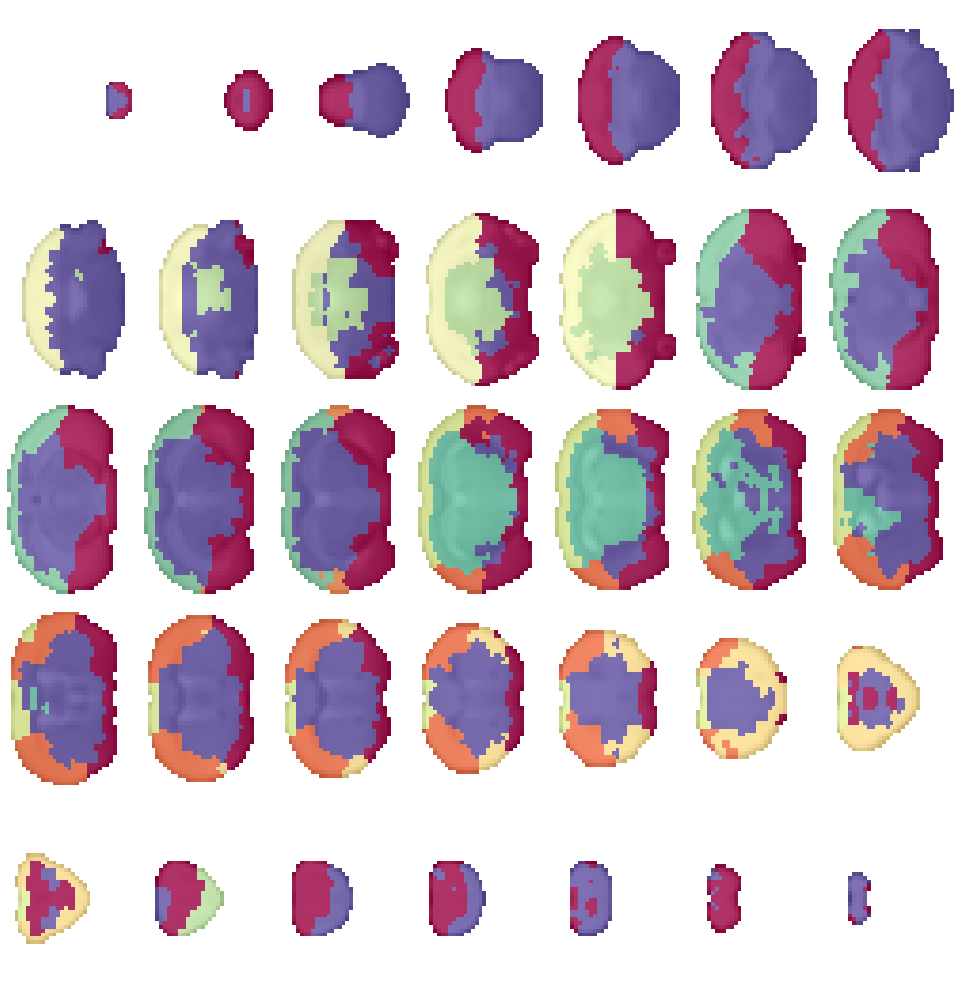

In [32]:
mask_tr, in_house_tr, cl_vol_tr = filter_boundaries([mask, in_house.numpy(), cl_vol], mask)
fig, axes = create_figure(5, 7, (13.5, 14))

for i, idx in enumerate(range(1, mask_tr.shape[-1], 2)):
    ax = axes.ravel()[i]

    x2plt = np.ma.masked_where(~mask_tr[..., idx], in_house_tr[..., idx])
    ax.imshow(x2plt, cmap='Greys_r')

    x2plt = np.ma.masked_where(~mask_tr[..., idx], cl_vol_tr[..., idx])
    ax.imshow(x2plt, alpha=0.8, cmap='Spectral')

remove_ticks(axes)
plt.show()

In [35]:
from register.register import reset_ants_img

In [36]:
img = reset_ants_img(
    in_house_tr, in_house.spacing, dtype='uint32', use_um=False)
ants.image_write(img, pjoin(tmp_dir, 'in_house.nii.gz'))

In [37]:
n_clusters = 8

result = get_clust_graph(
    linkage_mat=linkage,
    labels=list(roi_masks),
    num_clusters=n_clusters,
)
cl_vol = np.zeros(mask.shape, dtype=float)
for c_idx, clist in result['cluster_assigns'].items():
    for region in clist:
        cl_vol[roi_masks[region]] = c_idx
        
cl_vol_tr = filter_boundaries(cl_vol, mask)
img = reset_ants_img(
    cl_vol_tr, in_house.spacing, dtype='uint32', use_um=False)

ants.image_write(img, pjoin(tmp_dir, f'hier{n_clusters}.nii.gz'))